In [132]:
import numpy as np
import matplotlib.pyplot as plt

In [133]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


In [134]:
# --- CONSTANTS ---
n = 2
z_eval = np.linspace(0, 2, 200)

In [135]:
# --------------------------------------------------------------------------------
# Best-fit parameters for each model
# --------------------------------------------------------------------------------
params = {
    "CPL": {
        "M": -19.3374,
        "om": 0.286253,
        "obh2": 0.0223,
        "w0": -1.01341,
        "wa": -0.342229,
        "ga": 0.322089,
        "σ8": 0.780831,
        "h": 0.705644
    },
    "LOG": {
        "M": -19.3388,
        "om": 0.286815,
        "obh2": 0.0223,
        "w0": -1.01715,
        "wa": -0.255526,
        "ga": 0.311666,
        "σ8": 0.781457,
        "h": 0.705222
    },
    "BA": {
        "M": -19.3378,
        "om": 0.286084,
        "obh2": 0.0223,
        "w0": -1.02846,
        "wa": -0.163445,
        "ga": 0.321522,
        "σ8": 0.780939,
        "h": 0.705802
    },
    "JBP": {
        "M": -19.3337,
        "om": 0.283648,
        "obh2": 0.022493,
        "w0": -1.03197,
        "wa": -0.357571,
        "ga": 0.347624,
        "σ8": 0.781186,
        "h": 0.707511
    }
}

# --------------------------------------------------------------------------------
# CPL full covariance (om, w0, wa, ga)  (CovMarginal)
# --------------------------------------------------------------------------------
cov_cpl = np.array([
    [0.000215636,  0.00226876,  -0.00661639, -0.00281314],
    [0.00226876,   0.0262516,   -0.0797778,  -0.0307732],
    [-0.00661639, -0.0797778,    0.253849,    0.0894571],
    [-0.00281314, -0.0307732,    0.0894571,   0.0435601]
])

In [136]:
# μG
# --------------------------------------------------------------------------------
def muG(z, ga):
    x = z / (1.0 + z)
    return 1.00002 + ga * x**n - ga * x**(2 * n)

# --------------------------------------------------------------------------------
# Dark energy evolution factors
# --------------------------------------------------------------------------------
def f_CPL(z, w0, wa):
    return np.exp(-(3 * wa * z) / (1 + z)) * (1 + z)**(3 * (1 + w0 + wa))

def f_LOG(z, w0, wa):
    return (1 + z)**(3 + 3 * w0 + 1.5 * wa * np.log(1 + z))

def f_BA(z, w0, wa):
    return (1 + z)**(3 + 3 * w0) * (1 + z**2)**(1.5 * wa)

def f_JBP(z, w0, wa):
    return np.exp((3 * wa * z**2) / (2 * (1 + z)**2)) * (1 + z)**(3 + 3 * w0)

# --------------------------------------------------------------------------------
# q(z) = H^2/H0^2 for each model
# --------------------------------------------------------------------------------
def q_CPL(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_CPL(z, w0, wa)
def q_LOG(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_LOG(z, w0, wa)
def q_BA (z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_BA (z, w0, wa)
def q_JBP(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_JBP(z, w0, wa)

def q1_CPL(z, om, w0, wa): return derivative(lambda zz: q_CPL(zz, om, w0, wa), z)
def q1_LOG(z, om, w0, wa): return derivative(lambda zz: q_LOG(zz, om, w0, wa), z)
def q1_BA (z, om, w0, wa): return derivative(lambda zz: q_BA (zz, om, w0, wa), z)
def q1_JBP(z, om, w0, wa): return derivative(lambda zz: q_JBP(zz, om, w0, wa), z)

In [137]:
# --------------------------------------------------------------------------------
# ODE for F(z)
# --------------------------------------------------------------------------------
def F_ode(z, y, model, om, w0, wa, ga):
    F, Fp = y
    if model == "CPL":
        qv, q1v = q_CPL(z, om, w0, wa), q1_CPL(z, om, w0, wa)
    elif model == "LOG":
        qv, q1v = q_LOG(z, om, w0, wa), q1_LOG(z, om, w0, wa)
    elif model == "BA":
        qv, q1v = q_BA(z, om, w0, wa), q1_BA(z, om, w0, wa)
    else:
        qv, q1v = q_JBP(z, om, w0, wa), q1_JBP(z, om, w0, wa)

    mu = muG(z, ga)
    Fpp = -(2/(1+z) + q1v/(2*qv)) * Fp
    Fpp += (q1v/(qv*(1+z))) * F
    Fpp -= (3*(1+z)/qv) * om
    Fpp -= (Fp**2 * (4 - 3*mu*F)) / (2*F*(mu*F - 1))
    return [Fp, Fpp]

# --------------------------------------------------------------------------------
# Solve F(z)
# --------------------------------------------------------------------------------
def solve_F(model, om, w0, wa, ga, z_grid):
    y0 = [1.0, 0.0]
    sol = solve_ivp(
        lambda z, y: F_ode(z, y, model, om, w0, wa, ga),
        [z_grid[0], z_grid[-1]],
        y0,
        t_eval=z_grid,
        method='BDF',
        rtol=1e-8,
        atol=1e-10
    )
    if not sol.success:
        raise RuntimeError(f"ODE failed for {model}: {sol.message}")
    return sol.y[0]

# --------------------------------------------------------------------------------
# Compute central F(z) for all models
# --------------------------------------------------------------------------------
F_models = {}
for model in ["CPL", "LOG", "BA", "JBP"]:
    p = params[model]
    F_models[model] = solve_F(model, p["om"], p["w0"], p["wa"], p["ga"], z_eval)

# --------------------------------------------------------------------------------
# CPL uncertainty: propagate full covariance (om, w0, wa, ga)
# --------------------------------------------------------------------------------
central_cpl = [params["CPL"]["om"], params["CPL"]["w0"], params["CPL"]["wa"], params["CPL"]["ga"]]

# finite-difference step sizes (tuned)
deltas = [
    5e-5,    # om
    2e-3,    # w0
    2e-3,    # wa
    1e-3     # ga
]

def partial_derivative_F(z_idx, param_index):
    base = central_cpl.copy()
    base[param_index] += deltas[param_index]
    F_plus = solve_F("CPL", base[0], base[1], base[2], base[3], z_eval)[z_idx]
    base[param_index] -= 2*deltas[param_index]
    F_minus = solve_F("CPL", base[0], base[1], base[2], base[3], z_eval)[z_idx]
    return (F_plus - F_minus) / (2*deltas[param_index])

F_cpl = F_models["CPL"]
F_err = np.zeros_like(F_cpl)

for i in range(len(z_eval)):
    grad = np.array([partial_derivative_F(i, j) for j in range(4)])  # dF/d(om,w0,wa,ga)
    var = grad @ cov_cpl @ grad
    if var < 0:  # numerical guard
        var = 0.0
    F_err[i] = np.sqrt(var)

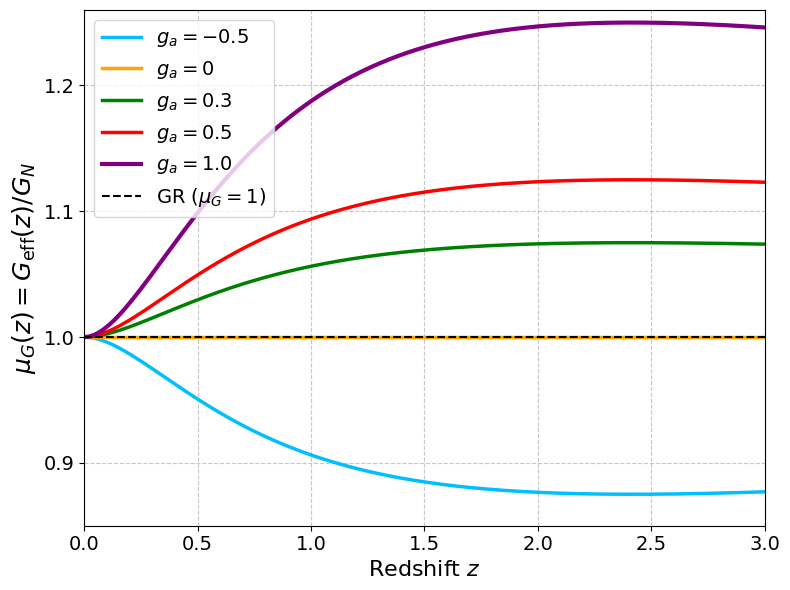

In [138]:


# --- CONSTANTS ---
n = 2
z_eval = np.linspace(0, 3, 300)

# --- μ_G(z) ---
def muG(z, ga):
    x = z/(1+z)
    return 1.00002 + ga * x**n - ga * x**(2*n)

# --- Fixed ga values and styles/colors to match image ---
ga_values = [-0.5, 0.0, 0.3, 0.5, 1.0]
plot_colors = {
    -0.5: "deepskyblue",  # blue
    0.0: "orange",
    0.3: "green",
    0.5: "red",
    1.0: "purple"
}
plot_styles = {
    -0.5: "solid",
    0.0: "solid",
    0.3: "solid",
    0.5: "solid",
    1.0: "solid"
}

legend_labels = {
    -0.5: r"$g_a = -0.5$",
    0.0: r"$g_a = 0$",
    0.3: r"$g_a = 0.3$",
    0.5: r"$g_a = 0.5$",
    1.0: r"$g_a = 1.0$"
}

plt.figure(figsize=(8, 6))

for ga in ga_values:
    mu_vals = muG(z_eval, ga)
    plt.plot(z_eval, mu_vals,
             color=plot_colors[ga],
             linestyle=plot_styles[ga],
             linewidth=2.5 if ga != 1.0 else 3,
             label=legend_labels[ga])

# Reference line (GR: muG = 1)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1.5, label=r"GR $(\mu_G = 1)$")

plt.xlabel(r"Redshift $z$", fontsize=16)
plt.ylabel(r"$\mu_G(z) = G_\mathrm{eff}(z)/G_N$", fontsize=18)
plt.xlim(0, 3)
plt.ylim(0.85, 1.26)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=14, loc="upper left")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

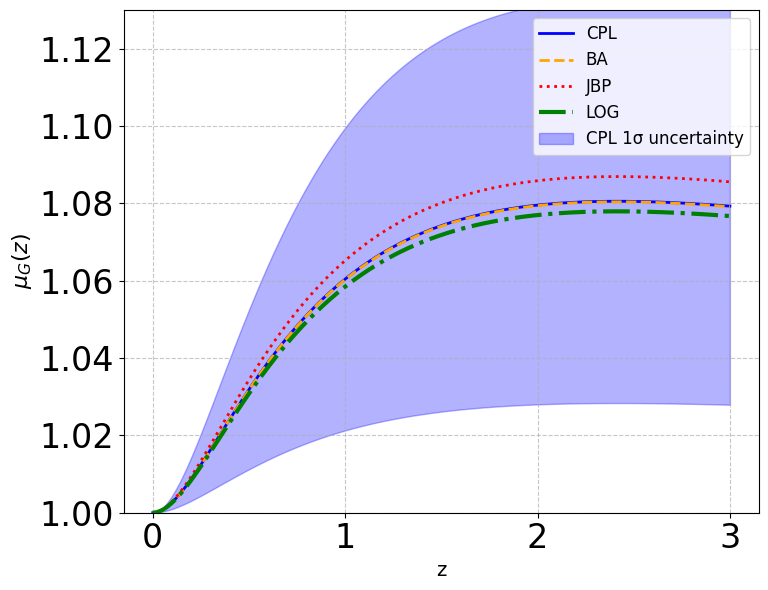

In [139]:



# --- μ_G(z) ---
def muG(z, ga):
    x = z/(1+z)
    return 1.00002 + ga * x**n - ga * x**(2*n)

# dμ/dγ_a
def dmu_dga(z):
    x = z/(1+z)
    return x**n - x**(2*n)

# Error (only gamma variance term)
def muG_error(z, ga, var_ga):
    grad = dmu_dga(z)
    return np.sqrt(grad**2 * var_ga)

# --- PLOT ---
plt.figure(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

# Plot CPL, BA, JBP first
for model in ["CPL", "BA", "JBP"]:
    ga = params[model]["ga"]
    mu_vals = muG(z_eval, ga)
    plt.plot(z_eval, mu_vals,
             color=colors[model],
             linestyle=styles[model],
             linewidth=2,
             label=model)

# LOG last (thicker)
ga_log = params["LOG"]["ga"]
mu_log = muG(z_eval, ga_log)
plt.plot(z_eval, mu_log,
         color=colors["LOG"],
         linestyle=styles["LOG"],
         linewidth=3,
         label="LOG")

# CPL uncertainty band
ga_cpl = params["CPL"]["ga"]
mu_cpl = muG(z_eval, ga_cpl)
ga_var = cov_cpl[3, 3]
mu_err = muG_error(z_eval, ga_cpl, ga_var)

plt.fill_between(z_eval,
                 mu_cpl - mu_err,
                 mu_cpl + mu_err,
                 color=colors["CPL"],
                 alpha=0.30,
                 label="CPL 1σ uncertainty")



plt.xlabel("z", fontsize=14)
plt.ylabel(r"$\mu_G(z)$", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(1, 1.13)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3133640330.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


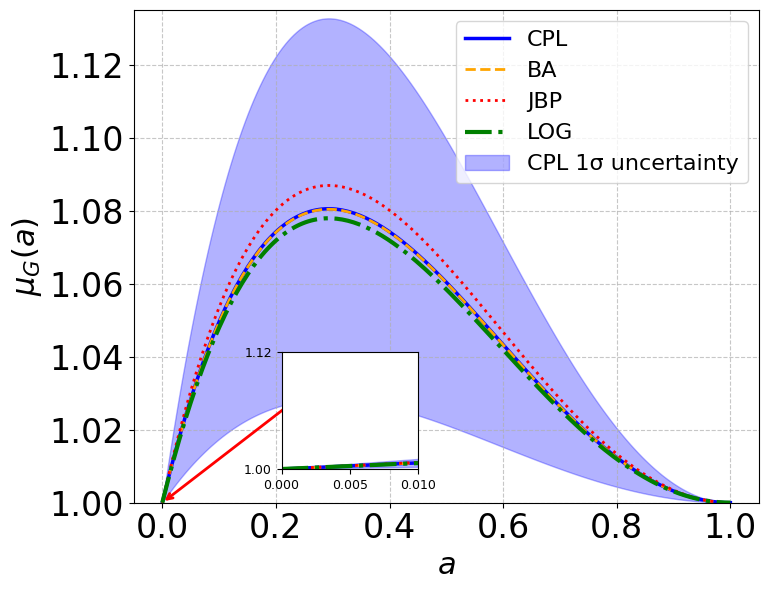

In [140]:

from matplotlib.patches import Rectangle


a_eval = np.linspace(0, 1, 200)


CovMarginalga = 0.0435601



def dmu_dga_a(a, n):
    x = 1 - a
    return x**n - x**(2*n)

def muG_error_a(a, n, var_ga):
    grad = dmu_dga_a(a, n)
    return np.sqrt(grad**2 * var_ga)

# --- Main plot ---
fig, ax = plt.subplots(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

for model in ["CPL", "BA", "JBP"]:
    ga = params[model]["ga"]
    mu_vals = muG_a(a_eval, n, ga)
    ax.plot(a_eval, mu_vals,
            color=colors[model],
            linestyle=styles[model],
            linewidth=2 if model != "CPL" else 2.5,
            label=model)

ga_log = params["LOG"]["ga"]
mu_log = muG_a(a_eval, n, ga_log)
ax.plot(a_eval, mu_log,
        color=colors["LOG"],
        linestyle=styles["LOG"],
        linewidth=3,
        label="LOG")

ga_cpl = params["CPL"]["ga"]
mu_cpl = muG_a(a_eval, n, ga_cpl)
mu_err = muG_error_a(a_eval, n, CovMarginalga)
ax.fill_between(a_eval,
                mu_cpl - mu_err,
                mu_cpl + mu_err,
                color=colors["CPL"],
                alpha=0.30,
                label="CPL 1σ uncertainty")

# Remove 1/F from legend and plot (not plotted here)

ax.set_xlabel(r"$a$", fontsize=22)
ax.set_ylabel(r"$\mu_G(a)$", fontsize=22)
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(fontsize=16)
ax.set_ylim(1, 1.135) # <--- Y limit of the main plot

# --- Inset/zoomed plot for a~0 (CMB region) ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---- CHANGE THIS PART OF THE CODE TO ADJUST FRAME SIZE AND PLACEMENT ----
# To change y-range of the frame, change axins.set_ylim(1, 1.01) below.
# To change the size of the frame, adjust width and height.
# To change the placement, adjust bbox_to_anchor parameters.

axins = inset_axes(ax, width="60%", height="8%", loc="lower center",
                   bbox_to_anchor=(.13, 1.0001, 0.40, 0.40), bbox_transform=ax.transData, borderpad=2)
# ------------------------------------------------------------------------

a_zoom = np.linspace(0, 0.01, 200)
for model in ["CPL", "BA", "JBP"]:
    ga = params[model]["ga"]
    mu_vals_zoom = muG_a(a_zoom, n, ga)
    axins.plot(a_zoom, mu_vals_zoom,
               color=colors[model],
               linestyle=styles[model],
               linewidth=2 if model != "CPL" else 2.5)
ga_log = params["LOG"]["ga"]
mu_log_zoom = muG_a(a_zoom, n, ga_log)
axins.plot(a_zoom, mu_log_zoom,
           color=colors["LOG"], linestyle=styles["LOG"], linewidth=3)
ga_cpl = params["CPL"]["ga"]
mu_cpl_zoom = muG_a(a_zoom, n, ga_cpl)
mu_err_zoom = muG_error_a(a_zoom, n, CovMarginalga)
axins.fill_between(a_zoom, mu_cpl_zoom - mu_err_zoom, mu_cpl_zoom + mu_err_zoom,
                   color=colors["CPL"], alpha=0.30)
axins.set_xlim(0, 0.01)
axins.set_ylim(1, 1.12) # <--- Y range of the frame (zoomed plot)
axins.set_xticks([0, 0.005, 0.01])
axins.set_yticks([1.0, 1.12])
axins.tick_params(axis='both', labelsize=9)

# Draw an arrow from inset to main plot, pointing to (a=0, μ_G(a)=1)
ax.annotate('', xy=(0, 1), xytext=(0.25, 1.03),
            textcoords='data', arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=2))

plt.tight_layout()
plt.show()

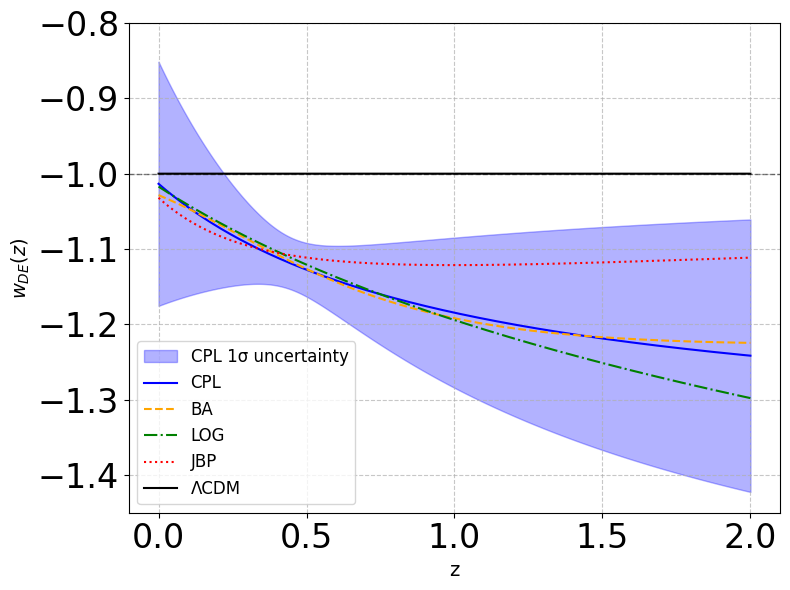

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Redshift range
z = np.linspace(0, 2, 1400)

# best-fit parameters for all models
parametrizations = {
    "CPL": {
        "w0": -1.01341,
        "wa": -0.342229,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z),
    },
    "BA": {
        "w0": -1.02846,
        "wa": -0.163445,
        "func": lambda z, w0, wa: w0 + wa * z * (1.0 + z) / (1.0 + z**2),
    },
    "LOG": {
        "w0": -1.01715,
        "wa": -0.255526,
        "func": lambda z, w0, wa: w0 + wa * np.log(1.0 + z),
    },
    "JBP": {
        "w0": -1.03197,
        "wa": -0.357571,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z)**2,
    },
    "ΛCDM": {
        "w0": -1.0,
        "wa": 0.0,
        "func": lambda z, w0, wa: w0 + 0*z,
    },
}

#  Covariance matrix for CPL (w0, wa) --
cov_cpl = np.array([
    [0.0262516, -0.0797778],   # [Var(w0), Cov(w0,wa)]
    [-0.0797778, 0.253849]     # [Cov(wa,w0), Var(wa)]
    ])



# Function to compute CPL error
def w_cpl_error(z, cov):
    grad_w0 = np.ones_like(z)
    grad_wa = z / (1 + z)
    variance = np.zeros_like(z)
    for i in range(len(z)):
        grad = np.array([grad_w0[i], grad_wa[i]])
        variance[i] = grad @ cov @ grad
    return np.sqrt(variance)

# Compute CPL central curve and error
w_cpl_central = parametrizations["CPL"]["func"](
    z,
    parametrizations["CPL"]["w0"],
    parametrizations["CPL"]["wa"]
)
w_cpl_error_vals = w_cpl_error(z, cov_cpl)

# --- PLOT ---
plt.figure(figsize=(8, 6))

colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red", "ΛCDM": "black"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted", "ΛCDM": "solid"}

for name, p in parametrizations.items():
    if name == "CPL":
        plt.fill_between(
            z,
            w_cpl_central - w_cpl_error_vals,
            w_cpl_central + w_cpl_error_vals,
            color=colors[name], alpha=0.3, label=f"{name} 1σ uncertainty"
        )
        plt.plot(
            z, w_cpl_central, label=name,
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )
    else:
        w_of_z = p["func"](z, p["w0"], p["wa"])
        plt.plot(
            z, w_of_z, label=name,
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )

plt.axhline(-1, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
plt.xlabel("z", fontsize=14)
plt.ylabel(r"$w_{DE}(z)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12, loc="lower left", frameon=True)
plt.ylim(-1.45, -.8)
plt.tight_layout()
plt.show()

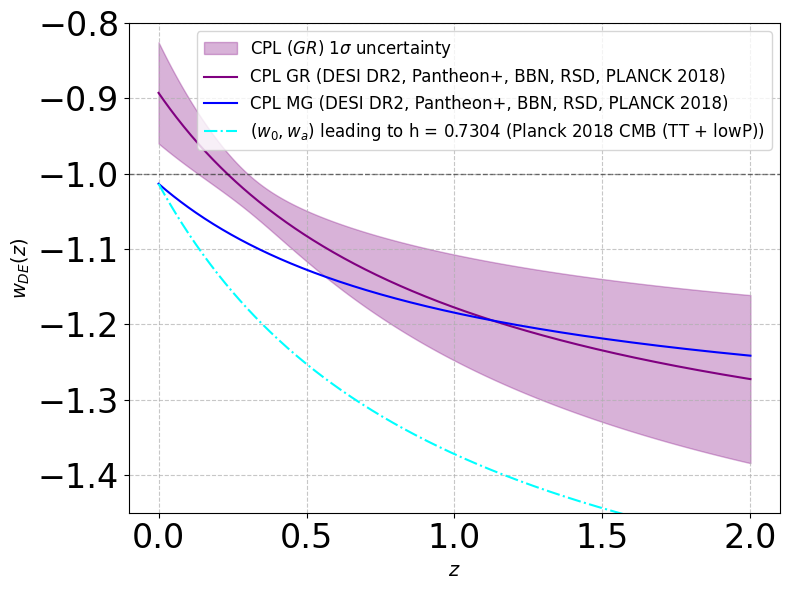

In [142]:
import numpy as np
import matplotlib.pyplot as plt

# Redshift range
z = np.linspace(0.0, 2.0, 400)


parametrizations = {
    "CPL (g_a=0)": {
        "w0": -0.892741,
        "wa": -0.569866,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z),
    },
    "CPL": {
        "w0": -1.01341,
        "wa": -0.342229,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z),
    },
    "Custom": {
        "w0": -1.01341,
        "wa": -0.717612,
        "func": lambda z, w0, wa: w0 + wa * (z / (1.0 + z)),  # w(z) = w0 + wa*(z/(1+z))
    },
}

# Covariance matrix for CPL (g_a=0) case
cov_cpl_g0 = np.array([
    [0.00451259, -0.0161022 ],
    [-0.0161022,  0.066138 ]
])

# Function to compute CPL error
def w_cpl_error(z, cov):
    grad_w0 = np.ones_like(z)
    grad_wa = z / (1 + z)
    variance = np.zeros_like(z)
    for i in range(len(z)):
        grad = np.array([grad_w0[i], grad_wa[i]])
        variance[i] = grad @ cov @ grad
    return np.sqrt(variance)

# Compute CPL ($g_a=0$) central curve and error
w_cpl_g0_central = parametrizations["CPL (g_a=0)"]["func"](
    z,
    parametrizations["CPL (g_a=0)"]["w0"],
    parametrizations["CPL (g_a=0)"]["wa"]
)
w_cpl_g0_error_vals = w_cpl_error(z, cov_cpl_g0)

# --- PLOT ---
plt.figure(figsize=(8, 6))

colors = {
    "CPL": "blue",
    "CPL (g_a=0)": "purple",
    "Custom": "cyan"
}
styles = {
    "CPL": "solid",
    "CPL (g_a=0)": "solid",
    "Custom": "dashdot"
}

for name in ["CPL (g_a=0)", "CPL", "Custom"]:
    p = parametrizations[name]
    w_of_z = p["func"](z, p["w0"], p["wa"])
    if name == "CPL (g_a=0)":
        plt.fill_between(
            z,
            w_cpl_g0_central - w_cpl_g0_error_vals,
            w_cpl_g0_central + w_cpl_g0_error_vals,
            color=colors[name], alpha=0.3,
            label=r"CPL $(GR)$ 1$\sigma$ uncertainty"
        )
    if name == "Custom":
        plt.plot(
            z, w_of_z,
            label=r"$(w_0, w_a)$ leading to h = 0.7304 (Planck 2018 CMB (TT + lowP))",
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )
    else:
        # Use proper LaTeX for CPL and CPL (g_a=0)
        if name == "CPL (g_a=0)":
            plot_label = r"CPL GR (DESI DR2, Pantheon+, BBN, RSD, PLANCK 2018)"
        else:
            plot_label = r"CPL MG (DESI DR2, Pantheon+, BBN, RSD, PLANCK 2018)"
        plt.plot(
            z, w_of_z, label=plot_label,
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )

plt.axhline(-1, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
plt.xlabel(r"$z$", fontsize=14)
plt.ylabel(r"$w_{DE}(z)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.ylim(-1.45, -0.8)
plt.tight_layout()
plt.show()

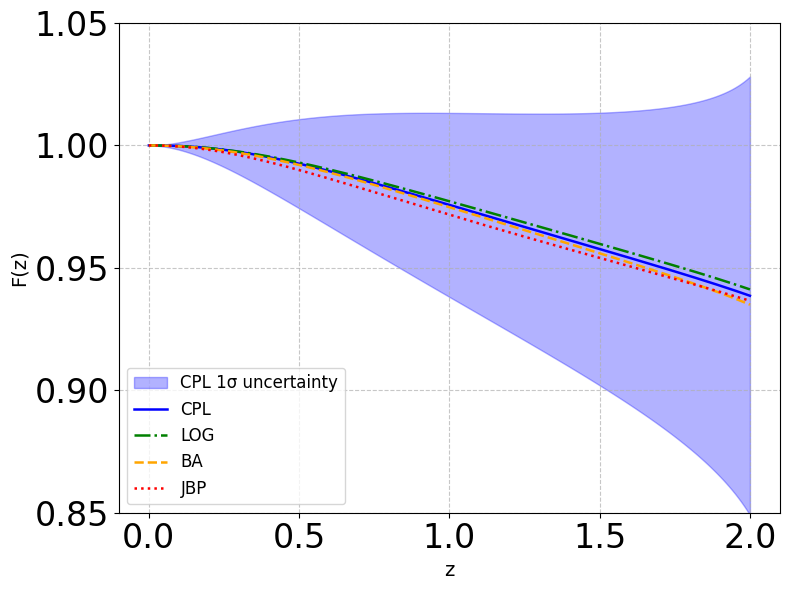

In [143]:
# Plot
# --------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

# Ensure z_eval matches the length of F_cpl and F_err (200 points from 0 to 2)
z_eval = np.linspace(0, 2, 200)

# Fill CPL band
plt.fill_between(z_eval,
                 F_cpl - F_err,
                 F_cpl + F_err,
                 color=colors["CPL"], alpha=0.30, label="CPL 1σ uncertainty")

# Central curves
for model in ["CPL", "LOG", "BA", "JBP"]:
    plt.plot(z_eval, F_models[model],
             color=colors[model],
             linestyle=styles[model],
             linewidth=1.8,
             label=model)

plt.xlabel("z", fontsize=14)
plt.ylabel("F(z)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12, loc="best")
plt.ylim(0.85, 1.05)
plt.tight_layout()
plt.show()

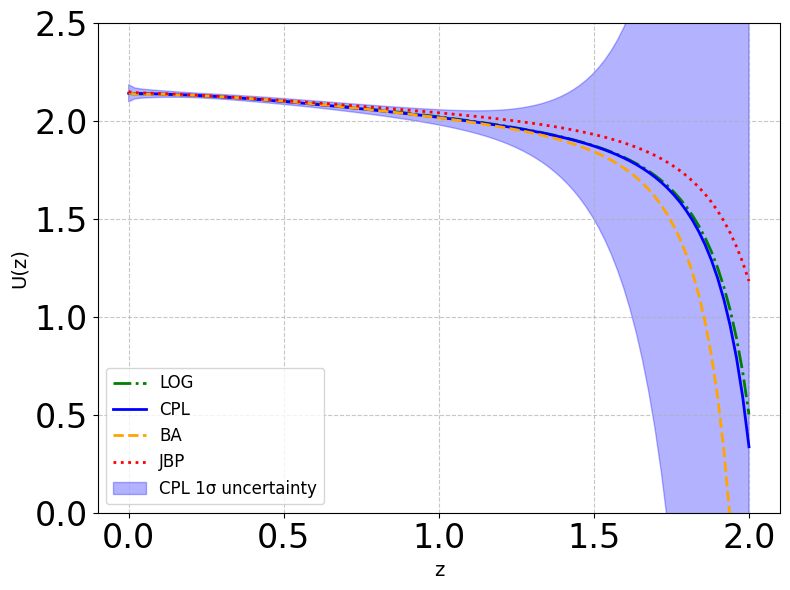

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# ✅ Central-difference derivative
def derivative(func, x, dx=1e-5, n=1):
    if n == 1:
        return (func(x + dx) - func(x - dx)) / (2 * dx)
    elif n == 2:
        return (func(x + dx) - 2 * func(x) + func(x - dx)) / (dx ** 2)
    else:
        raise ValueError("Only first and second derivatives are supported.")

# --- PARAMETERS ---
n = 2
z_eval = np.linspace(0, 2, 100)

# --------------------------------------------------------------------------------
# Best-fit parameters (NEW) for each model
# --------------------------------------------------------------------------------
params = {
    "CPL": {
        "M": -19.3374,
        "om": 0.286253,
        "obh2": 0.0223,
        "w0": -1.01341,
        "wa": -0.342229,
        "ga": 0.322089,
        "σ8": 0.780831,
        "h": 0.705644
    },
    "LOG": {
        "M": -19.3388,
        "om": 0.286815,
        "obh2": 0.0223,
        "w0": -1.01715,
        "wa": -0.255526,
        "ga": 0.311666,
        "σ8": 0.781457,
        "h": 0.705222
    },
    "BA": {
        "M": -19.3378,
        "om": 0.286084,
        "obh2": 0.0223,
        "w0": -1.02846,
        "wa": -0.163445,
        "ga": 0.321522,
        "σ8": 0.780939,
        "h": 0.705802
    },
    "JBP": {
        "M": -19.3337,
        "om": 0.283648,
        "obh2": 0.022493,
        "w0": -1.03197,
        "wa": -0.357571,
        "ga": 0.347624,
        "σ8": 0.781186,
        "h": 0.707511
    }
}

# --------------------------------------------------------------------------------
# CPL full covariance (om, w0, wa, ga)  (CovMarginal)
# --------------------------------------------------------------------------------
cov_cpl = np.array([
    [0.000215636,  0.00226876,  -0.00661639, -0.00281314],
    [0.00226876,   0.0262516,   -0.0797778,  -0.0307732],
    [-0.00661639, -0.0797778,    0.253849,    0.0894571],
    [-0.00281314, -0.0307732,    0.0894571,   0.0435601]
])

# --- FUNCTIONS ---
def muG(z, ga):
    return 1.00002 + ga * (z/(1+z))**n - ga * (z/(1+z))**(2*n)

def f_CPL(z, w0, wa): return np.exp(-(3 * wa * z) / (1 + z)) * (1 + z)**(3 * (1 + w0 + wa))
def f_BA(z, w0, wa):  return (1 + z)**(3 + 3 * w0) * (1 + z**2)**(3 * wa / 2)
def f_JBP(z, w0, wa): return np.exp((3 * wa * z**2) / (2 * (1 + z)**2)) * (1 + z)**(3 + 3 * w0)
def f_LOG(z, w0, wa): return (1 + z)**(3 + 3 * w0 + (3/2) * wa * np.log(1 + z))

def q_CPL(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_CPL(z, w0, wa)
def q_BA(z, om, w0, wa):  return om * (1 + z)**3 + (1 - om) * f_BA(z, w0, wa)
def q_JBP(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_JBP(z, w0, wa)
def q_LOG(z, om, w0, wa): return om * (1 + z)**3 + (1 - om) * f_LOG(z, w0, wa)

def q1_CPL(z, om, w0, wa): return derivative(lambda x: q_CPL(x, om, w0, wa), z)
def q1_BA(z, om, w0, wa):  return derivative(lambda x: q_BA(x, om, w0, wa), z)
def q1_JBP(z, om, w0, wa): return derivative(lambda x: q_JBP(x, om, w0, wa), z)
def q1_LOG(z, om, w0, wa): return derivative(lambda x: q_LOG(x, om, w0, wa), z)

def F_ode(z, y, model, om, w0, wa, ga):
    F, Fp = y
    if model == "CPL":
        qv, q1v = q_CPL(z, om, w0, wa), q1_CPL(z, om, w0, wa)
    elif model == "BA":
        qv, q1v = q_BA(z, om, w0, wa), q1_BA(z, om, w0, wa)
    elif model == "JBP":
        qv, q1v = q_JBP(z, om, w0, wa), q1_JBP(z, om, w0, wa)
    else:
        qv, q1v = q_LOG(z, om, w0, wa), q1_LOG(z, om, w0, wa)

    muG_val = muG(z, ga)
    Fpp = -(2/(1+z) + q1v/(2*qv)) * Fp \
          + (q1v/(qv*(1+z))) * F \
          - (3*(1+z)/qv) * om \
          - (Fp**2 * (4 - 3*muG_val*F)) / (2*F*(muG_val*F - 1))
    return [Fp, Fpp]

def solve_F(model, om, w0, wa, ga):
    y0 = [1, 0]
    sol = solve_ivp(lambda z, y: F_ode(z, y, model, om, w0, wa, ga),
                    [0, 2], y0, method='BDF', t_eval=z_eval,
                    rtol=1e-8, atol=1e-10)
    return sol

def compute_U(model, om, w0, wa, ga):
    sol = solve_F(model, om, w0, wa, ga)
    F = sol.y[0]; Fp = sol.y[1]

    # ✅ Compute F''(z) analytically from ODE
    Fpp = np.zeros_like(F)
    for j, z in enumerate(z_eval):
        Fpp[j] = F_ode(z, [F[j], Fp[j]], model, om, w0, wa, ga)[1]

    # Reconstruct q and q1 arrays
    if model == "CPL":
        qv = q_CPL(z_eval, om, w0, wa)
        q1v = np.array([q1_CPL(z, om, w0, wa) for z in z_eval])
    elif model == "BA":
        qv = q_BA(z_eval, om, w0, wa)
        q1v = np.array([q1_BA(z, om, w0, wa) for z in z_eval])
    elif model == "JBP":
        qv = q_JBP(z_eval, om, w0, wa)
        q1v = np.array([q1_JBP(z, om, w0, wa) for z in z_eval])
    else:
        qv = q_LOG(z_eval, om, w0, wa)
        q1v = np.array([q1_LOG(z, om, w0, wa) for z in z_eval])

    U = (qv/2) * (1+z_eval)**2 * Fpp \
        + (((1+z_eval)**2 * q1v)/4 - 2*qv*(1+z_eval)) * Fp \
        + (3*qv - (1+z_eval)*q1v/2) * F \
        - (3/2)*(1+z_eval)**3 * om
    return U

def U_error(z_index, central_params, cov):
    om, w0, wa, ga = central_params
    grad = np.zeros(4)
    delta = 1e-4
    for i in range(4):
        p = [om, w0, wa, ga]
        p[i] += delta
        U_plus = compute_U("CPL", *p)
        p[i] -= 2*delta
        U_minus = compute_U("CPL", *p)
        grad[i] = (U_plus[z_index] - U_minus[z_index]) / (2*delta)
    return np.sqrt(grad @ cov @ grad)

# --- PLOT ---
plt.figure(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

for model in ["LOG", "CPL", "BA", "JBP"]:
    p = params[model]
    U = compute_U(model, p["om"], p["w0"], p["wa"], p["ga"])
    plt.plot(z_eval, U, label=model, color=colors[model], linestyle=styles[model], linewidth=2)

central_params_cpl = [params["CPL"]["om"], params["CPL"]["w0"], params["CPL"]["wa"], params["CPL"]["ga"]]
U_cpl = compute_U("CPL", *central_params_cpl)
U_cpl_err = np.array([U_error(i, central_params_cpl, cov_cpl) for i in range(len(z_eval))])
plt.fill_between(z_eval, U_cpl - U_cpl_err, U_cpl + U_cpl_err,
                 color=colors["CPL"], alpha=0.3, label="CPL 1σ uncertainty")

plt.xlabel("z", fontsize=14)
plt.ylabel("U(z)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0, 2.5)
plt.tight_layout()
plt.show()

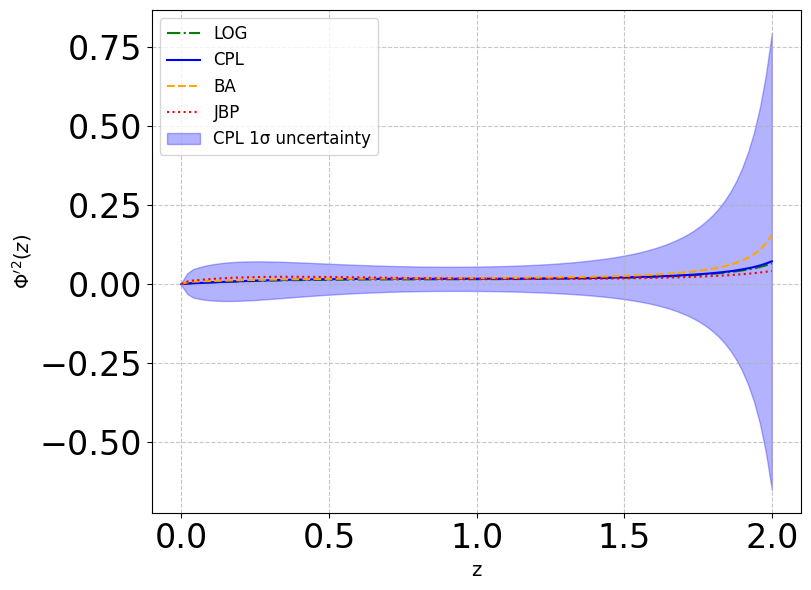

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

# --- Central difference derivative ---
def derivative(func, x, dx=1e-5):
    return (func(x + dx) - func(x - dx)) / (2 * dx)



def F_ode(z, y, model, om, w0, wa, ga):
    F, Fp = y
    if model == "CPL":
        qv, q1v = q_CPL(z, om, w0, wa), q1_CPL(z, om, w0, wa)
    elif model == "LOG":
        qv, q1v = q_LOG(z, om, w0, wa), q1_LOG(z, om, w0, wa)
    elif model == "BA":
        qv, q1v = q_BA(z, om, w0, wa), q1_BA(z, om, w0, wa)
    else:
        qv, q1v = q_JBP(z, om, w0, wa), q1_JBP(z, om, w0, wa)

    mu = muG(z, ga)
    Fpp = -(2/(1+z) + q1v/(2*qv)) * Fp
    Fpp += (q1v/(qv*(1+z))) * F
    Fpp -= (3*(1+z)/qv) * om
    Fpp -= (Fp**2 * (4 - 3*mu*F)) / (2*F*(mu*F - 1))
    return [Fp, Fpp]

def solve_F(model, om, w0, wa, ga):
    y0 = [1.0, 0.0]
    sol = solve_ivp(lambda z, Y: F_ode(z, Y, model, om, w0, wa, ga),
                    [0.0, 2.0], y0, t_eval=z_eval, method='BDF',
                    rtol=1e-8, atol=1e-10)
    return sol.t, sol.y[0], sol.y[1]

def phi_squared(model, om, w0, wa, ga):
    z_g, F, Fp = solve_F(model, om, w0, wa, ga)
    # Smooth second derivative via spline on F'
    Fp_spline = CubicSpline(z_g, Fp)
    Fpp = Fp_spline(z_g, 1)

    if model == "CPL":
        qv = q_CPL(z_g, om, w0, wa); q1v = np.array([q1_CPL(z, om, w0, wa) for z in z_g])
    elif model == "LOG":
        qv = q_LOG(z_g, om, w0, wa); q1v = np.array([q1_LOG(z, om, w0, wa) for z in z_g])
    elif model == "BA":
        qv = q_BA (z_g, om, w0, wa); q1v = np.array([q1_BA (z, om, w0, wa) for z in z_g])
    else:
        qv = q_JBP(z_g, om, w0, wa); q1v = np.array([q1_JBP(z, om, w0, wa) for z in z_g])

    phi2 = -Fpp - (2/(1+z_g) + q1v/(2*qv))*Fp + (q1v/(qv*(1+z_g)))*F - (3*(1+z_g)*om)/qv
    return np.interp(z_eval, z_g, phi2)

# --- CPL φ'^2 uncertainty ---
def phi2_error(z_index, central_params, cov, delta=1e-4):
    om, w0, wa, ga = central_params
    grad = np.zeros(4)
    for i in range(4):
        p_plus  = [om, w0, wa, ga]
        p_minus = [om, w0, wa, ga]
        p_plus[i]  += delta
        p_minus[i] -= delta
        val_plus  = phi_squared("CPL", *p_plus)[z_index]
        val_minus = phi_squared("CPL", *p_minus)[z_index]
        grad[i] = (val_plus - val_minus) / (2*delta)
    var = grad @ cov @ grad
    return np.sqrt(var) if var > 0 else 0.0

# --- Plot ---
plt.figure(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

# Central curves
phi2_cache = {}
for model in ["LOG", "CPL", "BA", "JBP"]:
    p = params[model]
    phi2 = phi_squared(model, p["om"], p["w0"], p["wa"], p["ga"])
    phi2_cache[model] = phi2
    plt.plot(z_eval, phi2, label=model, color=colors[model],
             linestyle=styles[model], linewidth=1.5)

# CPL band
central_cpl = [params["CPL"]["om"], params["CPL"]["w0"], params["CPL"]["wa"], params["CPL"]["ga"]]
phi2_cpl = phi2_cache["CPL"]  # already computed
phi2_cpl_err = np.array([phi2_error(i, central_cpl, cov_cpl) for i in range(len(z_eval))])

plt.fill_between(z_eval,
                 phi2_cpl - phi2_cpl_err,
                 phi2_cpl + phi2_cpl_err,
                 color=colors["CPL"], alpha=0.30, label="CPL 1σ uncertainty")

plt.xlabel("z", fontsize=14)
plt.ylabel(r"$\Phi'^2(z)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

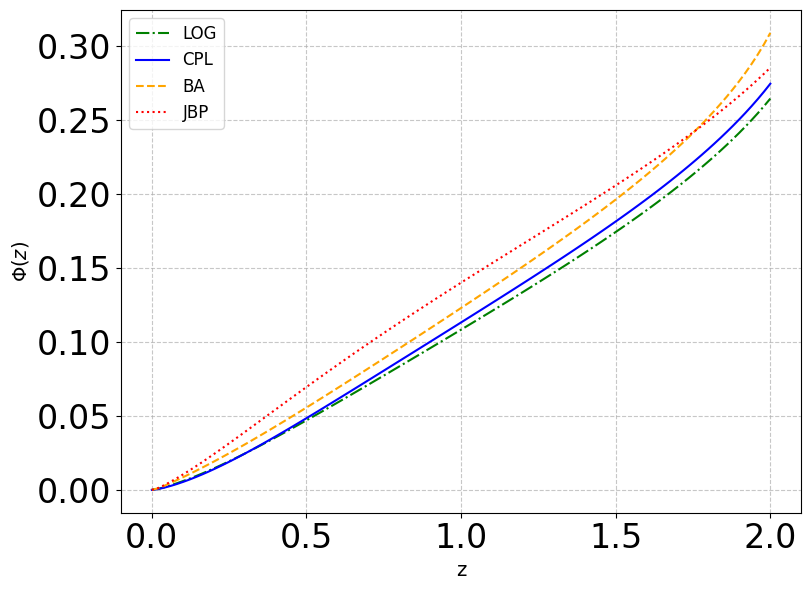

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.interpolate import CubicSpline, interp1d

# --- Small derivative ---
def derivative(func, x, dx=1e-5, n=1):
    if n == 1:
        return (func(x + dx) - func(x - dx)) / (2 * dx)
    elif n == 2:
        return (func(x + dx) - 2*func(x) + func(x - dx)) / dx**2
    else:
        raise ValueError("Only 1st and 2nd derivatives supported.")

        # --- Compute phi(z) non-piecewise ---
plt.figure(figsize=(8,6))
colors = {"LOG":"green","CPL":"blue","BA":"orange","JBP":"red"}
styles = {"LOG":"dashdot","CPL":"solid","BA":"dashed","JBP":"dotted"}

for model in ["LOG","CPL","BA","JBP"]:
    p = params[model]
    phi2_func = phi_squared(model,p["om"],p["w0"],p["wa"],p["ga"])
    phi_prime = np.sqrt(np.maximum(phi2_func,0))
    phi = cumulative_trapezoid(phi_prime, z_eval, initial=0.0)
    plt.plot(z_eval, phi, label=f"{model}", color=colors[model], linestyle=styles[model], linewidth=1.5)

plt.xlabel("z", fontsize=14)
plt.ylabel(r"$\Phi(z)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

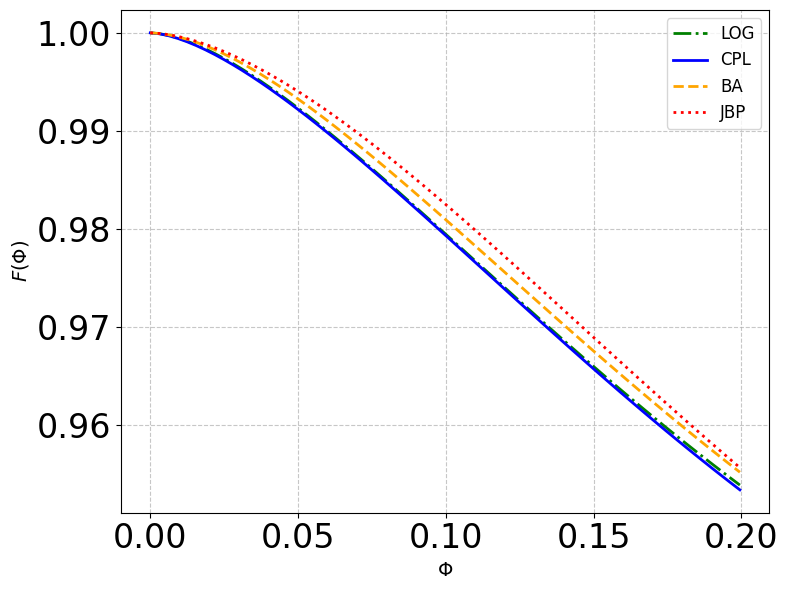

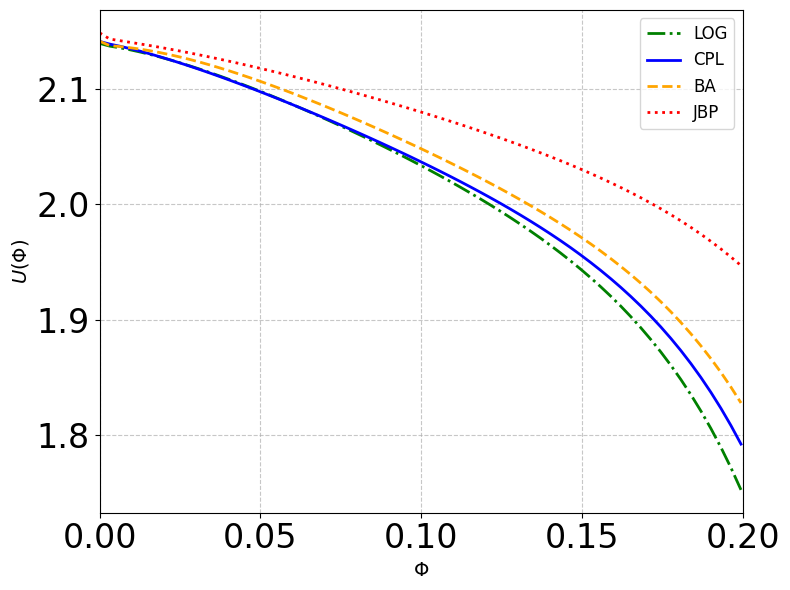

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, CubicSpline

# ✅ Custom central-difference derivative
def derivative(func, x, dx=1e-5, n=1):
    if n == 1:
        return (func(x + dx) - func(x - dx)) / (2 * dx)
    elif n == 2:
        return (func(x + dx) - 2 * func(x) + func(x - dx)) / (dx ** 2)
    else:
        raise ValueError("Only first and second derivatives are supported.")

# Constants
n = 2
z_CMB = 1089
z_range = (0, 2)
z_eval = np.linspace(0, 2, 100)

# --------------------------------------------------------------------------------
# Best-fit parameters (NEW) for each model
# --------------------------------------------------------------------------------
params = {
    "CPL": {
        "M": -19.3374,
        "om": 0.286253,
        "obh2": 0.0223,
        "w0": -1.01341,
        "wa": -0.342229,
        "ga": 0.322089,
        "σ8": 0.780831,
        "h": 0.705644
    },
    "LOG": {
        "M": -19.3388,
        "om": 0.286815,
        "obh2": 0.0223,
        "w0": -1.01715,
        "wa": -0.255526,
        "ga": 0.311666,
        "σ8": 0.781457,
        "h": 0.705222
    },
    "BA": {
        "M": -19.3378,
        "om": 0.286084,
        "obh2": 0.0223,
        "w0": -1.02846,
        "wa": -0.163445,
        "ga": 0.321522,
        "σ8": 0.780939,
        "h": 0.705802
    },
    "JBP": {
        "M": -19.3337,
        "om": 0.283648,
        "obh2": 0.022493,
        "w0": -1.03197,
        "wa": -0.357571,
        "ga": 0.347624,
        "σ8": 0.781186,
        "h": 0.707511
    }
}



# μG function
def muG(z, ga):
    return 1.00002 + ga * (z/(1+z))**n - ga * (z/(1+z))**(2*n)

# Dark energy functions
def f_CPL(z, w0, wa):
    return np.exp(-(3 * wa * z) / (1 + z)) * (1 + z)**(3 * (1 + w0 + wa))

def f_BA(z, w0, wa):
    return (1 + z)**(3 + 3 * w0) * (1 + z**2)**(3 * wa / 2)

def f_JBP(z, w0, wa):
    return np.exp((3 * wa * z**2) / (2 * (1 + z)**2)) * (1 + z)**(3 + 3 * w0)

def f_LOG(z, w0, wa):
    return (1 + z)**(3 + 3 * w0 + (3/2) * wa * np.log(1 + z))

# q(z) functions
def q_CPL(z, om, w0, wa):
    return om * (1 + z)**3 + (1 - om) * f_CPL(z, w0, wa)

def q_BA(z, om, w0, wa):
    return om * (1 + z)**3 + (1 - om) * f_BA(z, w0, wa)

def q_JBP(z, om, w0, wa):
    return om * (1 + z)**3 + (1 - om) * f_JBP(z, w0, wa)

def q_LOG(z, om, w0, wa):
    return om * (1 + z)**3 + (1 - om) * f_LOG(z, w0, wa)

# q'(z) functions using custom derivative
def q1_CPL(z, om, w0, wa):
    return derivative(lambda x: q_CPL(x, om, w0, wa), z)

def q1_BA(z, om, w0, wa):
    return derivative(lambda x: q_BA(x, om, w0, wa), z)

def q1_JBP(z, om, w0, wa):
    return derivative(lambda x: q_JBP(x, om, w0, wa), z)

def q1_LOG(z, om, w0, wa):
    return derivative(lambda x: q_LOG(x, om, w0, wa), z)

# Differential equation for F(z)
def F_ode(z, y, model, om, w0, wa, ga):
    F, Fp = y
    if model == "CPL":
        qv, q1v = q_CPL(z, om, w0, wa), q1_CPL(z, om, w0, wa)
    elif model == "BA":
        qv, q1v = q_BA(z, om, w0, wa), q1_BA(z, om, w0, wa)
    elif model == "JBP":
        qv, q1v = q_JBP(z, om, w0, wa), q1_JBP(z, om, w0, wa)
    else:
        qv, q1v = q_LOG(z, om, w0, wa), q1_LOG(z, om, w0, wa)

    muG_val = muG(z, ga)
    Fpp = - (2/(1+z) + q1v/(2*qv)) * Fp
    Fpp += (q1v/(qv*(1+z))) * F
    Fpp -= (3*(1+z)/qv) * om
    Fpp -= (Fp**2 * (4 - 3*muG_val*F)) / (2*F*(muG_val*F - 1))
    return [Fp, Fpp]

def solve_F(model, om, w0, wa, ga):
    y0 = [1.0, 0.0]
    sol = solve_ivp(lambda z, y: F_ode(z, y, model, om, w0, wa, ga),
                    [0.0, 2.0], y0, method='BDF', t_eval=z_eval,
                    rtol=1e-8, atol=1e-10)
    return sol

    # --- U(z) reconstruction (smooth F' and F'') ---
def compute_U(model, om, w0, wa, ga):
    sol = solve_F(model, om, w0, wa, ga)
    z_grid = sol.t
    F = np.clip(sol.y[0], 1e-6, None)  # avoid F ~ 0 singularities
    Fp = sol.y[1]

    # ✅ Use CubicSpline for smooth F'' instead of np.gradient
    Fp_spline = CubicSpline(z_grid, Fp)
    Fpp = Fp_spline(z_grid, 1)  # first derivative of F' = F''

    # Compute q(z), q'(z)
    if model == "CPL":
        qv = q_CPL(z_grid, om, w0, wa)
        q1v = np.array([q1_CPL(z, om, w0, wa) for z in z_grid])
    elif model == "BA":
        qv = q_BA(z_grid, om, w0, wa)
        q1v = np.array([q1_BA(z, om, w0, wa) for z in z_grid])
    elif model == "JBP":
        qv = q_JBP(z_grid, om, w0, wa)
        q1v = np.array([q1_JBP(z, om, w0, wa) for z in z_grid])
    else:
        qv = q_LOG(z_grid, om, w0, wa)
        q1v = np.array([q1_LOG(z, om, w0, wa) for z in z_grid])

    # ✅ Compute U(z) with smooth Fpp
    U = (qv/2) * (1+z_grid)**2 * Fpp \
        + (((1+z_grid)**2 * q1v)/4 - 2*qv*(1+z_grid)) * Fp \
        + (3*qv - (1+z_grid)*q1v/2) * F \
        - (3/2)*(1+z_grid)**3 * om

    return np.interp(z_eval, z_grid, U)



# --- φ'^2 using spline for F'' ---
def phi_squared(model, om, w0, wa, ga):
    sol = solve_F(model, om, w0, wa, ga)
    z_grid = sol.t
    F = sol.y[0]
    Fp = sol.y[1]

    Fp_spline = CubicSpline(z_grid, Fp)
    Fpp = Fp_spline(z_grid, 1)

    if model == "CPL":
        qv = q_CPL(z_grid, om, w0, wa)
        q1v = np.array([q1_CPL(z, om, w0, wa) for z in z_grid])
    elif model == "BA":
        qv = q_BA(z_grid, om, w0, wa)
        q1v = np.array([q1_BA(z, om, w0, wa) for z in z_grid])
    elif model == "JBP":
        qv = q_JBP(z_grid, om, w0, wa)
        q1v = np.array([q1_JBP(z, om, w0, wa) for z in z_grid])
    else:
        qv = q_LOG(z_grid, om, w0, wa)
        q1v = np.array([q1_LOG(z, om, w0, wa) for z in z_grid])

    phi2 = -Fpp - (2/(1+z_grid) + q1v/(2*qv))*Fp \
           + (q1v/(qv*(1+z_grid)))*F - (3*(1+z_grid)*om)/qv

    return np.interp(z_eval, z_grid, phi2)



# Solve ODE and compute solutions
solutions_F = {}
for model in ["LOG", "CPL", "BA", "JBP"]:
    p = params[model]
    sol = solve_F(model, p["om"], p["w0"], p["wa"], p["ga"])
    solutions_F[model] = interp1d(sol.t, sol.y[0], kind='cubic', bounds_error=False, fill_value='extrapolate')

# Compute Φ(z)
phi_solutions = {}
for model in ["LOG", "CPL", "BA", "JBP"]:
    p = params[model]
    phi2 = phi_squared(model, p["om"], p["w0"], p["wa"], p["ga"])
    phi_prime = np.sqrt(np.clip(phi2, 0, None))
    phi = cumulative_trapezoid(phi_prime, z_eval, initial=0.0)
    phi_solutions[model] = interp1d(z_eval, phi, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Compute z(Φ) by inverting Φ(z)
phi_range = np.linspace(min([phi_solutions[m](z_eval).min() for m in phi_solutions]),
                       max([phi_solutions[m](z_eval).max() for m in phi_solutions]), 100)
z_of_phi = {}
for model in ["LOG", "CPL", "BA", "JBP"]:
    z_of_phi[model] = interp1d(phi_solutions[model](z_eval), z_eval, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Compute F(Φ) and U(Φ)
F_of_phi = {}
U_of_phi = {}
for model in ["LOG", "CPL", "BA", "JBP"]:
    p = params[model]
    z_vals = z_of_phi[model](phi_range)
    F_of_phi[model] = solutions_F[model](z_vals)
    U_vals = compute_U(model, p["om"], p["w0"], p["wa"], p["ga"])
    U_of_phi[model] = np.interp(z_vals, z_eval, U_vals)

# --- Plot F(Φ) ---
plt.figure(figsize=(8, 6))
colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted"}

mask = phi_range <= 0.2
for model in ["LOG", "CPL", "BA", "JBP"]:
    plt.plot(phi_range[mask], F_of_phi[model][mask],
             label=model, color=colors[model], linestyle=styles[model], linewidth=2)

plt.xlabel(r"$\Phi$", fontsize=14)
plt.ylabel(r"$F(\Phi)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot U(Φ) ---
plt.figure(figsize=(8, 6))
mask = (phi_range >= 0.0) & (phi_range <= 0.2)
for model in ["LOG", "CPL", "BA", "JBP"]:
    plt.plot(phi_range[mask], U_of_phi[model][mask],
             label=model, color=colors[model], linestyle=styles[model], linewidth=2)

plt.xlabel(r"$\Phi$", fontsize=14)
plt.ylabel(r"$U(\Phi)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim([0, 0.2])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

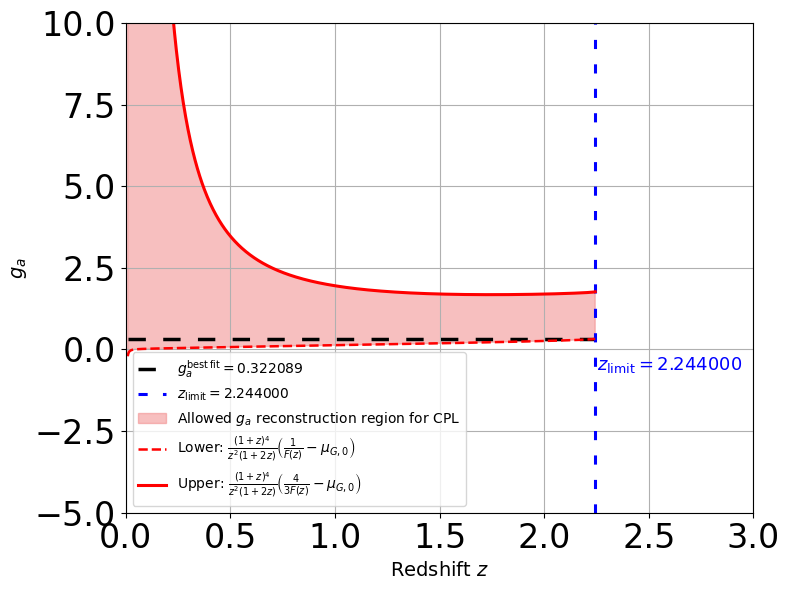

Reconstruction region ends at z_limit = 2.244000000000


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# --- CPL parameters ---
# params = {
#     "M": -19.3374,
#     "om": 0.286253,
#     "obh2": 0.0223,
# #     "w0": -1.01341,
#     "wa": -0.342229,
#     "ga": 0.322089,  # best-fit value for CPL
#     "σ8": 0.780831,
#     "h": 0.705644
# }
n = 2

def muG(z, ga):
    x = z / (1 + z)
    return 1.00002 + ga * x**n - ga * x**(2 * n)

def f_CPL(z, w0, wa):
    return np.exp(-(3 * wa * z) / (1 + z)) * (1 + z)**(3 * (1 + w0 + wa))

def q_CPL(z, om, w0, wa):
    return om * (1 + z)**3 + (1 - om) * f_CPL(z, w0, wa)

def derivative(func, x, dx=1e-5):
    return (func(x + dx) - func(x - dx)) / (2.0 * dx)

def q1_CPL(z, om, w0, wa):
    return derivative(lambda zz: q_CPL(zz, om, w0, wa), z)

def F_ode(z, y, model, om, w0, wa, ga):
    F, Fp = y
    if model == "CPL":
        qv, q1v = q_CPL(z, om, w0, wa), q1_CPL(z, om, w0, wa)
    elif model == "LOG":
        qv, q1v = q_LOG(z, om, w0, wa), q1_LOG(z, om, w0, wa)
    elif model == "BA":
        qv, q1v = q_BA(z, om, w0, wa), q1_BA(z, om, w0, wa)
    else:
        qv, q1v = q_JBP(z, om, w0, wa), q1_JBP(z, om, w0, wa)
    mu = muG(z, ga)
    Fpp = -(2/(1+z) + q1v/(2*qv)) * Fp \
          + (q1v/(qv*(1+z))) * F \
          - (3*(1+z)/qv) * om \
          - (Fp**2 * (4 - 3*mu*F)) / (2*F*(mu*F - 1))
    return [Fp, Fpp]

def solve_F(model, om, w0, wa, ga, z_grid):
    y0 = [1.0, 0.0]
    sol = solve_ivp(
        lambda z, y: F_ode(z, y, model, om, w0, wa, ga),
        [z_grid[0], z_grid[-1]],
        y0,
        t_eval=z_grid,
        method='BDF',
        rtol=1e-8,
        atol=1e-10
    )
    # Always interpolate solution onto the input z_grid
    F_interp = interp1d(sol.t, sol.y[0], kind="cubic", bounds_error=False, fill_value="extrapolate")
    Fz = F_interp(z_grid)
    return Fz

# --- Redshift range (avoid z=0) ---
z = np.linspace(0.01, 2.244, 800)

# --- Compute F(z) for CPL ---
Fz = solve_F("CPL", params["CPL"]["om"], params["CPL"]["w0"], params["CPL"]["wa"], params["CPL"]["ga"], z)

mu_G0 = 1.00002

# --- Calculate bounds using F(z) ---
lower = ((1 + z)**4 / (z**2 * (1 + 2*z))) * (1 / Fz - mu_G0)
upper = ((1 + z)**4 / (z**2 * (1 + 2*z))) * (4 / (3 * Fz) - mu_G0)

# --- Find crossing point of ga_bestfit and lower bound ---
ga_bestfit = params["CPL"]["ga"]
diff = lower - ga_bestfit
cross_indices = np.where((diff[1:] > 0) & (diff[:-1] <= 0))[0]
if len(cross_indices) > 0:
    z_cross_idx = cross_indices[0] + 1
    z_cross = z[z_cross_idx]
else:
    z_cross = None  # No crossing found

# --- Plot ---
plt.figure(figsize=(8,6))

# Bold dashed black best-fit line for ga
plt.plot(z, [ga_bestfit]*len(z),
         color='black', linestyle=(0, (5, 5)), linewidth=2.5,
         label=rf"$g_a^\mathrm{{best\,fit}} = {ga_bestfit:.6f}$")

# Vertical dashed line at crossing (blue, named z_limit)
if z_cross is not None:
    plt.axvline(x=z_cross, color='blue', linestyle=(0, (3, 5)), linewidth=2.2,
                label=rf"$z_{{\rm limit}}={z_cross:.6f}$")
    # Place label above line
    plt.text(z_cross+0.01, plt.ylim()[1]-0.5, f"$z_{{\\rm limit}}={z_cross:.6f}$", color='blue', fontsize=13, va='top', ha='left')

# Allowed region
plt.fill_between(z, lower, upper, color='lightcoral', alpha=0.5, label=r'Allowed $g_a$ reconstruction region for CPL')
plt.plot(z, lower, 'r--', linewidth=1.8,
         label=r"Lower: $\frac{(1+z)^4}{z^2(1+2z)}\left(\frac{1}{F(z)}-\mu_{G,0}\right)$")
plt.plot(z, upper, 'r-', linewidth=2.2,
         label=r"Upper: $\frac{(1+z)^4}{z^2(1+2z)}\left(\frac{4}{3F(z)}-\mu_{G,0}\right)$")

plt.xlabel(r'Redshift $z$', fontsize=14)
plt.ylabel(r'$g_a$', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(-5, 10)
plt.tight_layout()
plt.show()

if z_cross is not None:
    print(f"Reconstruction region ends at z_limit = {z_cross:.12f}")
else:
    print("No crossing point found: best-fit ga does not cross lower bound in region.")

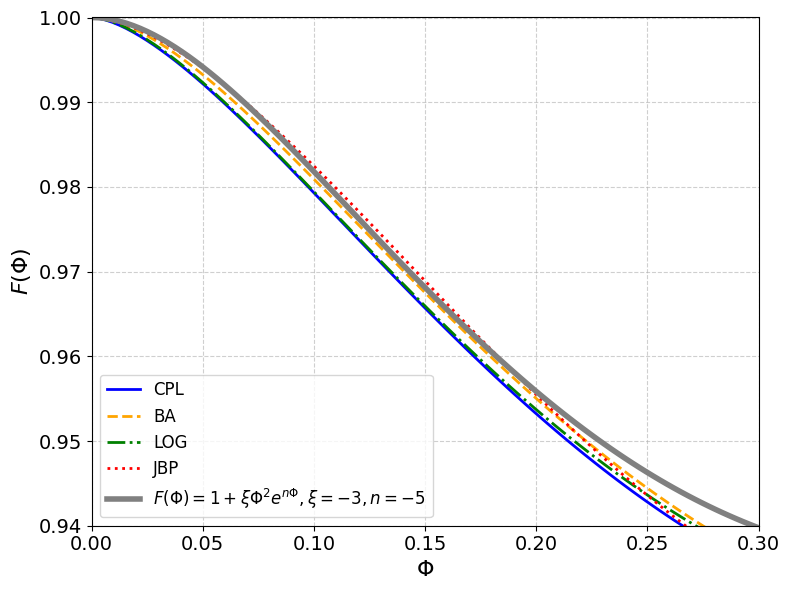

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Use phi_range defined earlier
model_names = ["CPL", "BA", "LOG", "JBP"]
colors = {"CPL": "blue", "BA": "orange", "LOG": "green", "JBP": "red"}
styles = {"CPL": "solid", "BA": "dashed", "LOG": "dashdot", "JBP": "dotted"}

def F_custom(phi, xi, n):
    return xi * phi**2 * np.exp(n * phi) + 1

# Manual parameters for trial function
xi_manual = -3
n_manual =-5

plt.figure(figsize=(8, 6))

for i, model in enumerate(model_names):
    F_interp = interp1d(phi_range, F_of_phi[model], kind='cubic', fill_value='extrapolate')
    F_vals = F_interp(phi_range)
    plt.plot(phi_range, F_vals, color=colors[model], linestyle=styles[model], lw=2, label=f"{model}")

# Plot single trial function with manual parameters
plt.plot(
    phi_range, F_custom(phi_range, xi_manual, n_manual), color='gray', lw=4,
    label=rf"$F(\Phi) = 1 +\xi \Phi^2 e^{{n\Phi}}, \xi={xi_manual}, n={n_manual}$" # Updated label here
)

plt.xlabel(r"$\Phi$", fontsize=16)
plt.ylabel(r"$F(\Phi)$", fontsize=16)
plt.xlim([0, 0.3])
plt.ylim([0.94, 1.00])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12, loc="lower left")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

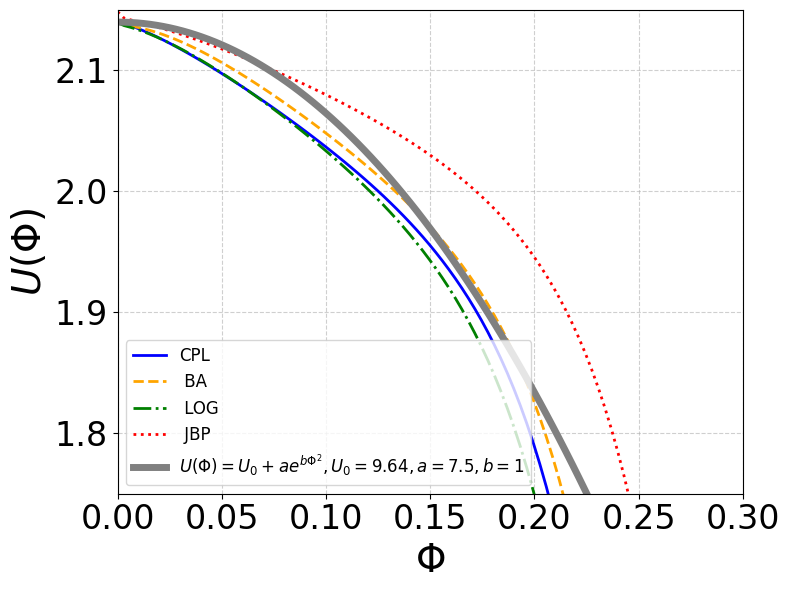

In [150]:
# 1. IMPORTS + COLAB
# ==============================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from google.colab import files

# ==============================================
# 2. GLOBAL FONT SIZES (EXACTLY AS YOU SAID)
# ==============================================
plt.rcParams["axes.labelsize"] = 28
plt.rcParams["xtick.labelsize"] = 24
plt.rcParams["ytick.labelsize"] = 24
plt.rcParams["legend.fontsize"] = 12 # Decreased legend font size
# --------------------------------------------------------------

# ==============================================
# 3. YOUR DATA (phi_range, U_of_phi must exist)
# ==============================================
phi_vals = phi_range  # Assuming phi_range is defined
model_names = ["CPL", "BA", "LOG", "JBP"]
colors = {"CPL": "blue", "BA": "orange", "LOG": "green", "JBP": "red"}
styles = {"CPL": "solid", "BA": "dashed", "LOG": "dashdot", "JBP": "dotted"}

# ==============================================
# 4. YOUR MANUAL VALUES (UNCHANGED)
# ==============================================
V0_manual = 9.64
alpha_manual = -7.5
beta_manual = 1

# ==============================================
# 5. YOUR FITTING FUNCTION (UNCHANGED)
# ==============================================
def U_pink_fixed(phi):
    return V0_manual + alpha_manual * np.exp(beta_manual * phi**2)

# ==============================================
# 6. PLOT (YOUR CODE, ONLY STYLE CHANGED)
# ==============================================
plt.figure(figsize=(8, 6))

for i, model in enumerate(model_names):
    U_vals = U_of_phi[model]
    if i == 0:
        plt.plot(phi_vals, U_vals, color=colors[model], linestyle=styles[model], lw=2,
                 label=rf"{model}")
    else:
        plt.plot(phi_vals, U_vals, color=colors[model], linestyle=styles[model], lw=2,
                 label=rf" {model}")

# THICK GRAY SOLID LINE (NOT DASHED) + U_0 IN LEGEND
plt.plot(phi_vals, U_pink_fixed(phi_vals), color='gray', linestyle='solid', lw=5,
         label=rf"$U(\Phi) = U_0 +a e^{{b\Phi^2}}, U_0=9.64, a=7.5, b=1$")

plt.xlabel(r"$\Phi$")
plt.ylabel(r"$U(\Phi)$")
plt.xlim([0, 0.3])
plt.ylim([1.75, 2.15])
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="lower left")
plt.tight_layout()

# ==============================================
# 7. SAVE + DOWNLOAD PDF
# ==============================================
pdf_name = "U_manual_fit.pdf"
plt.savefig(pdf_name, format="pdf", dpi=300, bbox_inches="tight")
plt.show()

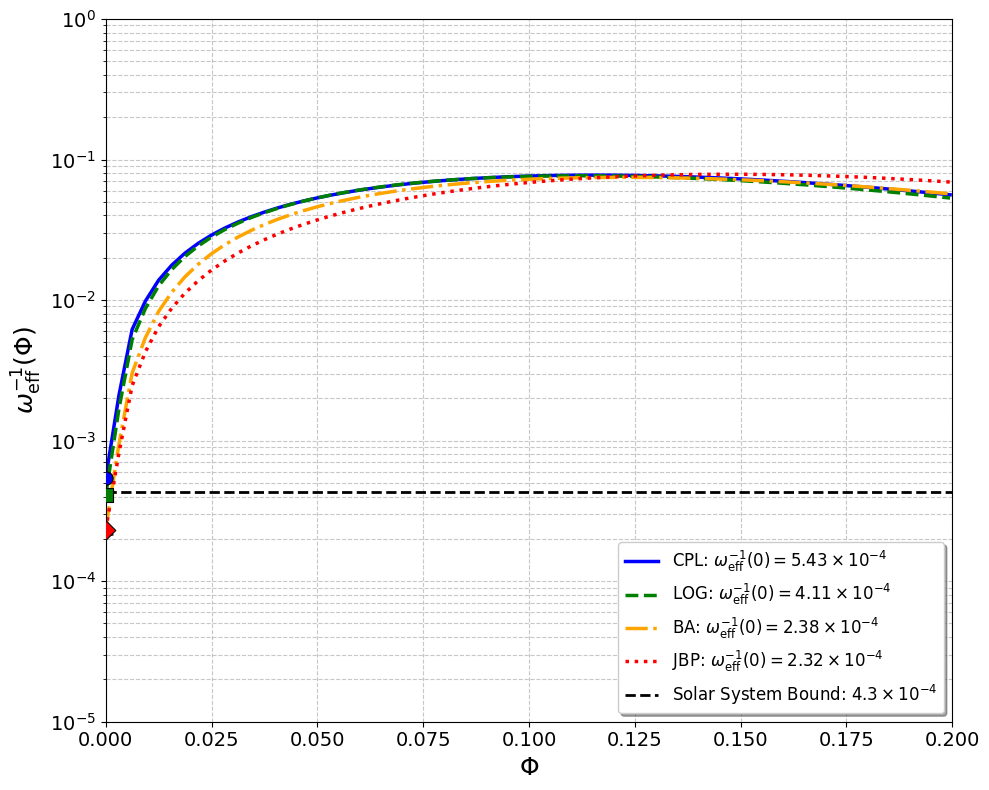


     ω_eff⁻¹(Φ=0) FOR ALL MODELS
 CPL:  5.43 × 10^-4   →   FAILED
 LOG:  4.11 × 10^-4   →   PASSED
  BA:  2.38 × 10^-4   →   PASSED
 JBP:  2.32 × 10^-4   →   PASSED
------------------------------------------------------------
Solar System Bound: 4.3 × 10⁻⁴


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# --- REQUIREMENTS: phi_range and F_of_phi must exist for all models ---
required_models = ["CPL", "LOG", "BA", "JBP"]
missing = [m for m in required_models if m not in F_of_phi]
if 'phi_range' not in globals():
    raise RuntimeError("phi_range not defined.")
if missing:
    raise RuntimeError(f"F_of_phi missing for: {', '.join(missing)}")

# Extract and sort all models
phi = np.asarray(phi_range)
models_data = {}

for model in required_models:
    F_model = np.asarray(F_of_phi[model])
    sort_idx = np.argsort(phi)
    phi_sorted = phi[sort_idx]
    F_sorted = F_model[sort_idx]

    # Cubic spline
    cs = CubicSpline(phi_sorted, F_sorted, bc_type='natural')
    dF_dphi = cs(phi_sorted, 1)
    F_safe = np.clip(F_sorted, 1e-12, None)
    omega_inv = (dF_dphi**2) / F_safe

    # Evaluate at Φ = 0
    phi0 = 0.0
    if phi_sorted.min() <= phi0 <= phi_sorted.max():
        dF0 = cs(phi0, 1)
        F0 = float(cs(phi0))
    else:
        idx = 0  # fallback to first point
        dF0 = dF_dphi[idx]
        F0 = F_safe[idx]
    omega0 = (dF0**2) / max(F0, 1e-12)

    #
    coeff = omega0
    if coeff > 0:
        exp = int(np.floor(np.log10(coeff)))
        mant = coeff / (10 ** exp)
    else:
        mant, exp = 0.0, 0
    mant = round(mant, 2)

    models_data[model] = {
        'phi': phi_sorted,
        'omega_inv': omega_inv,
        'omega0': omega0,
        'mant': mant,
        'exp': exp,
        'cs': cs
    }

# --- PLOT ALL MODELS ---
plt.figure(figsize=(10, 8))

colors = {"CPL": "blue", "LOG": "green", "BA": "orange", "JBP": "red"}
linestyles = {"CPL": "-", "LOG": "--", "BA": "-.", "JBP": ":"}
markers = {"CPL": "o", "LOG": "s", "BA": "^", "JBP": "D"}

constraint = 4.3e-4
mask = (phi >= 0.0) & (phi <= 0.2)

for model in required_models:
    data = models_data[model]
    # include omega0 value in the legend label with mantissa (2 decimals) and power of 10
    label_txt = rf"{model}: $\omega_{{\rm eff}}^{{-1}}(0) = {data['mant']:.2f}\times10^{{{data['exp']}}}$"
    plt.plot(data['phi'][mask], data['omega_inv'][mask],
             color=colors[model], linestyle=linestyles[model], linewidth=2.5,
             label=label_txt)

    # Mark Φ=0 point but do not add separate legend entry
    plt.scatter([0.0], [data['omega0']], color=colors[model], s=90, zorder=6,
                edgecolors='black', linewidth=0.8, marker=markers[model], label='_nolegend_')

# Solar system bound
plt.axhline(constraint, color='black', linestyle='--', linewidth=2,
            label=r"Solar System Bound: $4.3\times10^{-4}$")

# Final plot settings requested by user
plt.xlabel(r"$\Phi$", fontsize=18)      # axis titles 18
plt.ylabel(r"$\omega_{\rm eff}^{-1}(\Phi)$", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.7, which='both')
plt.legend(fontsize=12, loc="lower right", frameon=True, fancybox=True, shadow=True)  # legend 14
plt.xlim(0, 0.2)
plt.ylim(1e-5, 1e0)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)  # ticks fontsize 14

plt.tight_layout()
plt.show()

# --- CONSOLE SUMMARY ---
print("\n" + "="*60)
print("     ω_eff⁻¹(Φ=0) FOR ALL MODELS")
print("="*60)
for model in required_models:
    d = models_data[model]
    status = "PASSED" if d['omega0'] < constraint else "FAILED"
    print(f"{model:>4}:  {d['mant']:.2f} × 10^{d['exp']}   →   {status}")
print("-"*60)
print(f"Solar System Bound: 4.3 × 10⁻⁴")
print("="*60)

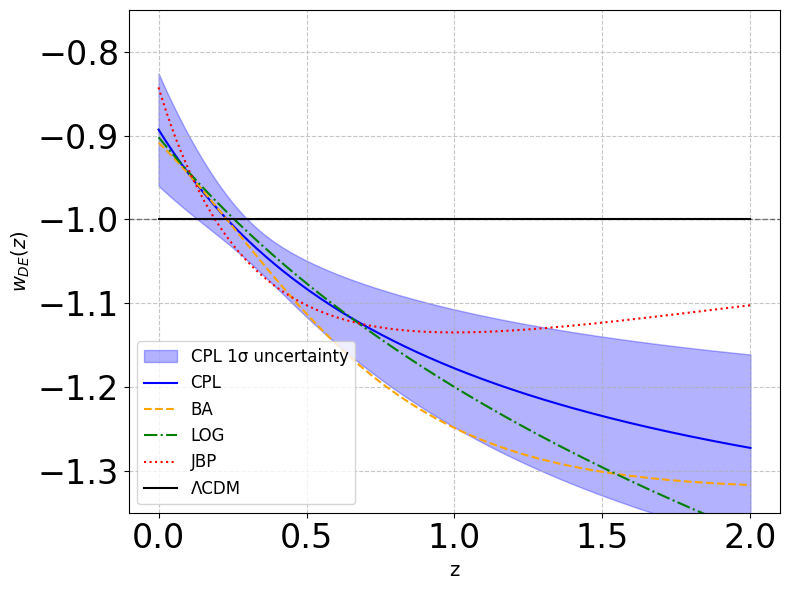

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Redshift range
z = np.linspace(0.0, 2.0, 400)

# Parametrizations with (w0, wa) for gamma_a=0 case
parametrizations = {
    "CPL": {
        "w0": -0.892741,
        "wa": -0.569866,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z),
    },
    "BA": {
        "w0": -0.90819,
        "wa": -0.340602,
        "func": lambda z, w0, wa: w0 + wa * z * (1.0 + z) / (1.0 + z**2),
    },
    "LOG": {
        "w0": -0.901835,
        "wa": -0.430136,
        "func": lambda z, w0, wa: w0 + wa * np.log(1.0 + z),
    },
    "JBP": {
        "w0": -0.842402,
        "wa": -1.16961,
        "func": lambda z, w0, wa: w0 + wa * z / (1.0 + z)**2,
    },
    "ΛCDM": {
        "w0": -1.0,
        "wa": 0.0,
        "func": lambda z, w0, wa: w0 + 0*z,
    },
}

# Covariance matrix for CPL (w0, wa)  (CovMarginalw, gamma_a=0 case)
cov_cpl = np.array([
    [0.00451259, -0.0161022 ],
    [-0.0161022,  0.066138 ]
])

# Function to compute CPL error
def w_cpl_error(z, cov):
    grad_w0 = np.ones_like(z)
    grad_wa = z / (1 + z)
    variance = np.zeros_like(z)
    for i in range(len(z)):
        grad = np.array([grad_w0[i], grad_wa[i]])
        variance[i] = grad @ cov @ grad
    return np.sqrt(variance)

# Compute CPL central curve and error
w_cpl_central = parametrizations["CPL"]["func"](
    z,
    parametrizations["CPL"]["w0"],
    parametrizations["CPL"]["wa"]
)
w_cpl_error_vals = w_cpl_error(z, cov_cpl)

# --- PLOT ---
plt.figure(figsize=(8, 6))

colors = {"LOG": "green", "CPL": "blue", "BA": "orange", "JBP": "red", "ΛCDM": "black"}
styles = {"LOG": "dashdot", "CPL": "solid", "BA": "dashed", "JBP": "dotted", "ΛCDM": "solid"}

for name, p in parametrizations.items():
    if name == "CPL":
        plt.fill_between(
            z,
            w_cpl_central - w_cpl_error_vals,
            w_cpl_central + w_cpl_error_vals,
            color=colors[name], alpha=0.3, label=f"{name} 1σ uncertainty"
        )
        plt.plot(
            z, w_cpl_central, label=name,
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )
    else:
        w_of_z = p["func"](z, p["w0"], p["wa"])
        plt.plot(
            z, w_of_z, label=name,
            color=colors[name], linestyle=styles[name], linewidth=1.5
        )

plt.axhline(-1, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
plt.xlabel("z", fontsize=14)
plt.ylabel(r"$w_{DE}(z)$", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12, loc="lower left", frameon=True)
plt.ylim(-1.35, -0.75)
plt.tight_layout()
plt.show()

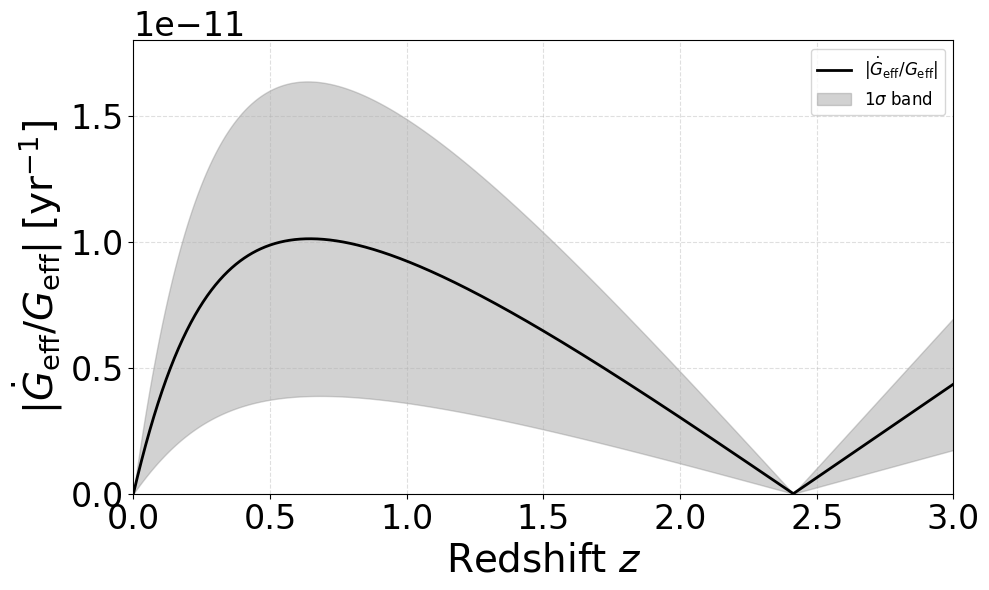

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Constants & best-fit params ----------------
Mpc_m = 3.085677581e22
Neff = 3.044
Omega_gamma_h2 = 2.4729e-5
sec_per_year = 365.0 * 24.0 * 3600.0

# Best-fit from fmwc5
best = {
    "M": -19.33738984974981,
    "om": 0.286252567505367,
    "obh2": 0.0223,
    "w0": -1.013406665170472,
    "wa": -0.34222910997496503,
    "ga": 0.32208887943795345,
    "s8": 0.7808305901073777,
    "h": 0.7056442892036879
}

# Full 8x8 covariance (as provided)
C_full = np.array([
 [ 0.00140567, -0.000533284,  1.85213e-6,  -0.00538997,  0.0149428,  0.00728679, -0.000302011,  0.000611744],
 [-0.000533284,  0.000215636, -8.30425e-7,   0.00226876, -0.00661639, -0.00281314,  0.000111372, -0.000242104],
 [ 1.85213e-6,  -8.30425e-7,   2.13703e-8,  -8.97638e-6,  3.26806e-5,  9.34443e-6, -2.01055e-7,   8.71477e-7],
 [-0.00538997,   0.00226876,  -8.97638e-6,   0.0262516,  -0.0797778,  -0.0307732,   0.00128095,  -0.00253455],
 [ 0.0149428,   -0.00661639,   3.26806e-5,  -0.0797778,   0.253849,    0.0894571,  -0.00359896,   0.00721524],
 [ 0.00728679,  -0.00281314,   9.34443e-6,  -0.0307732,   0.0894571,   0.0435601,  -0.00191552,   0.00319187],
 [-0.000302011,  0.000111372, -2.01055e-7,   0.00128095, -0.00359896, -0.00191552,   0.000707024, -0.000130512],
 [ 0.000611744, -0.000242104,  8.71477e-7,  -0.00253455,  0.00721524,  0.00319187,  -0.000130512,  0.000275832]
])

# Parameter order in fit: {M, om, obh2, w0, wa, ga, s8, h}
# We need indices (zero-based): 1->om, 3->w0, 4->wa, 5->ga, 7->h
param_names = ["om", "w0", "wa", "ga", "h"]
indices = [1, 3, 4, 5, 7]
C = C_full[np.ix_(indices, indices)]  # 5x5 covariance submatrix

# ---------------- helper functions ----------------
def Omega_r(h):
    return (Omega_gamma_h2 / h**2) * (1 + Neff * 7/8 * (4/11)**(4/3))

def f_a(a, w0, wa):
    return a**(-3*(1 + w0 + wa)) * np.exp(-3*wa*(1 - a))

def E_a(a, om, w0, wa, h):
    """Dimensionless H(a)/H0"""
    Or = Omega_r(h)
    return np.sqrt(om*a**-3 + Or*a**-4 + (1 - om - Or)*f_a(a, w0, wa))

def muGfull(a, n, ga):
    return 1.00002 + ga * (1 - a)**n - ga * (1 - a)**(2*n)

def dmugdz(z, ga):
    return - (2 * ga * z * (-1 + (-2 + z) * z)) / (1 + z)**5

# Use the same normalization as your Mathematica expression:
# prefactor = (-3.23) * h * 1e-18 * 3600 * 24 * 365
# H[a]/(100*h) corresponds to E_a(a)
def dotG_over_G_from_params(a, om, w0, wa, ga, h):
    z = 1.0 / a - 1.0
    mu = muGfull(a, 2, ga)
    prefactor = (-3.23) * h * 1e-18 * sec_per_year  # matches Mathematica usage
    E = E_a(a, om, w0, wa, h)
    return (1.0/mu) * prefactor * dmugdz(z, ga) * (1.0 + z) * E

# A wrapper that accepts vector p = [om,w0,wa,ga,h]
def F_of_a(a, p_vec):
    return dotG_over_G_from_params(a, p_vec[0], p_vec[1], p_vec[2], p_vec[3], p_vec[4])

# ---------------- gradient via finite differences ----------------
def gradient_F(a, p_vec, rel_eps=1e-6):
    grad = np.zeros_like(p_vec, dtype=float)
    f0 = F_of_a(a, p_vec)
    for i in range(len(p_vec)):
        eps = rel_eps * max(1.0, abs(p_vec[i]))
        dp = np.zeros_like(p_vec)
        dp[i] = eps
        f_plus = F_of_a(a, p_vec + dp)
        f_minus = F_of_a(a, p_vec - dp)
        grad[i] = (f_plus - f_minus) / (2.0 * eps)
    return grad

def sigma_F(a, p_vec, Cov):
    grad = gradient_F(a, p_vec)
    var = grad @ Cov @ grad
    return np.sqrt(np.abs(var))

# ---------------- compute grid ----------------
p_best = np.array([best["om"], best["w0"], best["wa"], best["ga"], best["h"]])

z_min, z_max, n_z = 0, 3.0, 1200
z_vals = np.linspace(z_min, z_max, n_z)
a_vals = 1.0 / (1.0 + z_vals)

F_z = np.array([F_of_a(a, p_best) for a in a_vals])
sigma_z = np.array([sigma_F(a, p_best, C) for a in a_vals])

# ---------------- plotting (linear-linear) ----------------
plt.figure(figsize=(10,6))
y = np.abs(F_z)
yerr = sigma_z
lower = np.maximum(0, np.abs(y - yerr))
upper = np.abs(y + yerr)

plt.plot(z_vals, y, color='black', lw=2, label=r'$|\dot G_{\rm eff}/G_{\rm eff}|$')
plt.fill_between(z_vals, lower, upper, color='gray', alpha=0.35, label=r'1$\sigma$ band')

plt.xlim(0, 3)
plt.ylim(0, np.max(upper)*1.1)
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$|\dot G_{\rm eff}/G_{\rm eff}|\; [\mathrm{yr}^{-1}]$')
plt.grid(True, ls='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


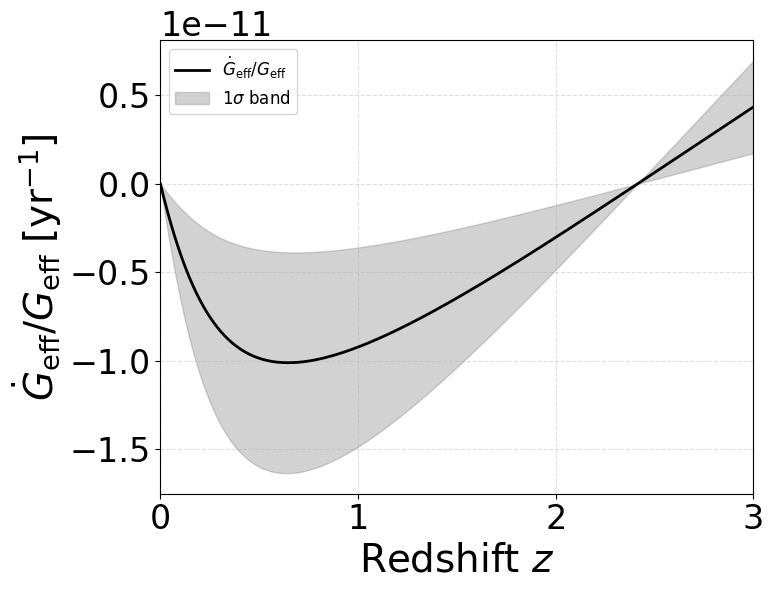

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Constants & best-fit params ----------------
Mpc_m = 3.085677581e22
Neff = 3.044
Omega_gamma_h2 = 2.4729e-5
sec_per_year = 365.0 * 24.0 * 3600.0

best = {
    "M": -19.33738984974981,
    "om": 0.286252567505367,
    "obh2": 0.0223,
    "w0": -1.013406665170472,
    "wa": -0.34222910997496503,
    "ga": 0.32208887943795345,
    "s8": 0.7808305901073777,
    "h": 0.7056442892036879
}

C_full = np.array([
 [ 0.00140567, -0.000533284,  1.85213e-6,  -0.00538997,  0.0149428,  0.00728679, -0.000302011,  0.000611744],
 [-0.000533284,  0.000215636, -8.30425e-7,   0.00226876, -0.00661639, -0.00281314,  0.000111372, -0.000242104],
 [ 1.85213e-6,  -8.30425e-7,   2.13703e-8,  -8.97638e-6,  3.26806e-5,  9.34443e-6, -2.01055e-7,   8.71477e-7],
 [-0.00538997,   0.00226876,  -8.97638e-6,   0.0262516,  -0.0797778,  -0.0307732,   0.00128095,  -0.00253455],
 [ 0.0149428,   -0.00661639,   3.26806e-5,  -0.0797778,   0.253849,    0.0894571,  -0.00359896,   0.00721524],
 [ 0.00728679,  -0.00281314,   9.34443e-6,  -0.0307732,   0.0894571,   0.0435601,  -0.00191552,   0.00319187],
 [-0.000302011,  0.000111372, -2.01055e-7,   0.00128095, -0.00359896, -0.00191552,   0.000707024, -0.000130512],
 [ 0.000611744, -0.000242104,  8.71477e-7,  -0.00253455,  0.00721524,  0.00319187,  -0.000130512,  0.000275832]
])

indices = [1, 3, 4, 5, 7]
C = C_full[np.ix_(indices, indices)]

# ---------------- helper functions ----------------
def Omega_r(h):
    return (Omega_gamma_h2 / h**2) * (1 + Neff * 7/8 * (4/11)**(4/3))

def f_a(a, w0, wa):
    return a**(-3*(1 + w0 + wa)) * np.exp(-3*wa*(1 - a))

def E_a(a, om, w0, wa, h):
    Or = Omega_r(h)
    return np.sqrt(om*a**-3 + Or*a**-4 + (1 - om - Or)*f_a(a, w0, wa))

def muGfull(a, n, ga):
    return 1.00002 + ga * (1 - a)**n - ga * (1 - a)**(2*n)

def dmugdz(z, ga):
    return - (2 * ga * z * (-1 + (-2 + z) * z)) / (1 + z)**5

def dotG_over_G_from_params(a, om, w0, wa, ga, h):
    z = 1.0 / a - 1.0
    mu = muGfull(a, 2, ga)
    prefactor = (-3.23) * h * 1e-18 * sec_per_year
    E = E_a(a, om, w0, wa, h)
    return (1.0/mu) * prefactor * dmugdz(z, ga) * (1.0 + z) * E

def F_of_a(a, p_vec):
    return dotG_over_G_from_params(a, *p_vec)

# ---------------- gradient via finite differences ----------------
def gradient_F(a, p_vec, rel_eps=1e-6):
    grad = np.zeros_like(p_vec, dtype=float)
    f0 = F_of_a(a, p_vec)
    for i in range(len(p_vec)):
        eps = rel_eps * max(1.0, abs(p_vec[i]))
        dp = np.zeros_like(p_vec)
        dp[i] = eps
        f_plus = F_of_a(a, p_vec + dp)
        f_minus = F_of_a(a, p_vec - dp)
        grad[i] = (f_plus - f_minus) / (2.0 * eps)
    return grad

def sigma_F(a, p_vec, Cov):
    grad = gradient_F(a, p_vec)
    var = grad @ Cov @ grad
    return np.sqrt(np.abs(var))

# ---------------- compute grid ----------------
p_best = np.array([best["om"], best["w0"], best["wa"], best["ga"], best["h"]])

z_min, z_max, n_z = 0, 3, 1000
z_vals = np.linspace(z_min, z_max, n_z)
a_vals = 1.0 / (1.0 + z_vals)

F_z = np.array([F_of_a(a, p_best) for a in a_vals])
sigma_z = np.array([sigma_F(a, p_best, C) for a in a_vals])

# ---------------- plotting (linear-linear, signed) ----------------
plt.figure(figsize=(8,6))
y = F_z
yerr = sigma_z
lower = y - yerr
upper = y + yerr

plt.plot(z_vals, y, color='black', lw=2, label=r'$\dot G_{\rm eff}/G_{\rm eff}$')
plt.fill_between(z_vals, lower, upper, color='gray', alpha=0.35, label=r'1$\sigma$ band')

plt.xlim(0, 3)
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$\dot G_{\rm eff}/G_{\rm eff}\; [\mathrm{yr}^{-1}]$')
plt.grid(True, ls='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
